# CSCA 5642:Introduction to Deep Learning Final Project
## ⚽ Predicting Football Match Outcomes with Deep Learning
**Name:** Olaniyi Nafiu

## Project Description
This project is based on the Kaggle competition [Football Match Probability Prediction](https://www.kaggle.com/competitions/football-match-probability-prediction).
The goal is to build a deep learning model using LSTM (Long Short-Term Memory) networks to predict the probability of a team winning, drawing, or losing a match based on historical match sequences. This will be done for more than 150000 match outcomes using the recent sequence of 10 matches of the teams.

### Task: Multi-class Classification


## Dataset
- **Source:** [Kaggle - Football Match Probability Prediction](https://www.kaggle.com/competitions/football-match-probability-prediction)

- **Description:**
  - 110,938 historical matches from 2019 to 2021, across 860+ leagues and 9,500+ teams.
  - Features are split into **descriptive** and **historical** types.
    - **Descriptive features:**
      - Include columns like: `target`, `home_team_name`, `away_team_name`, `is_cup`, etc.
    - **Historical features:**
      - Each match includes data from the last 10 games played by each team.
      - `is_play_home` indicates if the team played at home in those past games.
      - The most recent game is indexed at 1, the least recent at 10.
      - Columns include: `home_team_history_is_play_home_{i}`, `home_team_history_opponent_rating_{i}`, `away_team_history_is_play_home_{i}`, `away_team_history_opponent_rating_{i}`, etc.

- **Evaluation:** Multinomial [Log Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)

- **Submission:**
  - Columns: `id`, `home`, `draw`, `away`
  - Each value is a float between 0 and 1, and the sum of the three must equal 1.
  - `id` is the unique identifier for the predicted match.

> *Citation:* Kaggle Competition. (2024). *Football Match Probability Prediction.* https://www.kaggle.com/competitions/football-match-probability-prediction


In [52]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set color map to have light blue background
sns.set()
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import tensorflow as tf
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Exploratory Data Analysis (EDA)

In [10]:
# Load and explore dataset
# train = pd.read_csv('/kaggle/input/football-match-probability-prediction/train.csv')
# test = pd.read_csv('/kaggle/input/football-match-probability-prediction/test.csv')
train_df = pd.read_csv('../dataset/dl_final/train.csv')
test_df = pd.read_csv('../dataset/dl_final/test.csv')
train_df.head()

/var/folders/29/pcgxrbyn6nnbkh5g1dvhbb_m0000gn/T/ipykernel_35425/2418593250.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('../dataset/dl_final/train.csv')


match_date                         object
home_team_history_match_date_1     object
home_team_history_match_date_2     object
home_team_history_match_date_3     object
home_team_history_match_date_4     object
home_team_history_match_date_5     object
home_team_history_match_date_6     object
home_team_history_match_date_7     object
home_team_history_match_date_8     object
home_team_history_match_date_9     object
home_team_history_match_date_10    object
away_team_history_match_date_1     object
away_team_history_match_date_2     object
away_team_history_match_date_3     object
away_team_history_match_date_4     object
away_team_history_match_date_5     object
away_team_history_match_date_6     object
away_team_history_match_date_7     object
away_team_history_match_date_8     object
away_team_history_match_date_9     object
away_team_history_match_date_10    object
dtype: object

In [11]:
# Data set shape
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df.info())
train_df.describe()

Train shape: (110938, 190)
Test shape: (72711, 189)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110938 entries, 0 to 110937
Columns: 190 entries, id to away_team_history_league_id_10
dtypes: float64(162), int64(2), object(26)
memory usage: 160.8+ MB
None


,id,league_id,home_team_coach_id,away_team_coach_id,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
count,1.109380e+05,110938.000000,8.921700e+04,8.912300e+04,109779.000000,108487.000000,107165.000000,105837.000000,104461.000000,103042.000000,...,109712.000000,108345.000000,106904.000000,105422.000000,103938.000000,102512.000000,101071.000000,99643.000000,98176.000000,96722.000000
mean,1.519875e+07,910.457012,1.287134e+07,1.291552e+07,0.306944,0.567801,0.466141,0.519469,0.487857,0.507288,...,901.986200,894.389137,886.368012,878.243611,869.450297,861.901455,853.435338,844.673223,837.678200,829.177374
std,2.536393e+06,549.120985,1.578479e+07,1.580344e+07,0.461228,0.495384,0.498855,0.499623,0.499855,0.499949,...,545.826707,542.247411,538.497274,534.864981,531.170701,527.338931,524.217968,520.954647,517.647869,514.900676
min,1.142829e+07,2.000000,2.000000e+00,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,1.200038e+07,444.000000,4.596120e+05,4.595650e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,438.000000,432.000000,426.000000,420.000000,417.000000,408.000000,399.000000,391.500000,387.000000,387.000000
50%,1.675988e+07,947.000000,1.552728e+06,1.552806e+06,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,944.000000,935.000000,906.500000,899.000000,884.000000,881.000000,860.000000,830.000000,821.000000,806.000000
75%,1.724230e+07,1293.000000,3.243116e+07,3.279539e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1286.000000,1283.000000,1279.000000,1274.000000,1270.000000,1267.000000,1265.000000,1263.000000,1261.000000,1255.000000
max,1.805384e+07,2039.000000,3.756849e+07,3.756847e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2028.000000,2025.000000


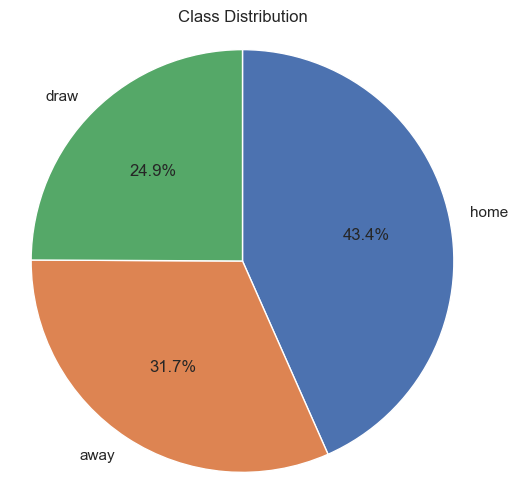

In [17]:
# Plot class distribution as a pie chart
class_counts = train_df['target'].value_counts()
labels = class_counts.index
sizes = class_counts.values

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title("Class Distribution")
plt.axis('equal')  # Equal aspect ratio ensures a perfect circle
plt.show()


In [13]:
# Check for missing values
missing = train_df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

away_team_history_coach_10       27129
home_team_history_coach_10       26653
away_team_history_coach_9        26150
home_team_history_coach_9        25733
away_team_history_coach_8        25219
                                 ...  
home_team_history_league_id_1     1159
away_team_name                       1
is_cup                               1
league_name                          1
home_team_name                       1
Length: 186, dtype: int64

In [14]:
# Clean data
def clean_match_data(df):
    # Replace all missing values for coach or league id with -1
    coach_cols = [col for col in df.columns if 'coach' in col]
    league_cols = [col for col in df.columns if 'league_id' in col]
    df[coach_cols] = df[coach_cols].fillna(-1)
    df[league_cols] = df[league_cols].fillna(-1)

    # Replace all missing values for _is_cup_* with 0 (not a cup match)
    is_cup_cols = [col for col in df.columns if '_is_cup_' in col]
    df[is_cup_cols] = df[is_cup_cols].fillna(0)

    # Replace missing values for rating and goal columns with median
    rating_goal_cols = [col for col in df.columns if '_rating_' in col or '_goal_' in col]
    for col in rating_goal_cols:
        df[col] = df[col].fillna(df[col].median())

    # Replace *_is_play_home_{i} with 0 (assume away)
    is_play_home_cols = [col for col in df.columns if 'is_play_home_' in col]
    df[is_play_home_cols] = df[is_play_home_cols].fillna(0)

    # Replace *_match_date_{i} with placeholder and convert to datetime
    placeholder_date = pd.to_datetime('1900-01-01')
    match_date_cols = [col for col in df.columns if 'match_date' in col]
    for col in match_date_cols:
        df[col] = pd.to_datetime(df[col].fillna(placeholder_date), errors='coerce')

    # Drop rows with missing values in important descriptive fields (only a few missing)
    cols_to_check = ['home_team_name', 'away_team_name', 'league_name', 'is_cup']
    df = df.dropna(subset=cols_to_check).reset_index(drop=True)

    return df
train_df = clean_match_data(train_df)

In [15]:
# Verify no values are missing
missing = train_df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [20]:
# Drop league_name columns league_id
if 'league_name' in train_df.columns:
    train_df = train_df.drop(columns='league_name')

## 🧠 Model Architecture
I'm using a simple LSTM-based architecture with the following structure:
- Input: sequences of past match stats (per team)
- LSTM layers
- Dense layer with softmax output (3 classes)

### Loss Function: Categorical Crossentropy
### Optimizer: Adam

In [30]:
# Define historical features to include
timesteps = 10
history_features = [
    'rating',
    'goal',
    'is_play_home',
    'is_cup',
    'opponent_rating',
    'opponent_goal'
]
sides = ['home', 'away']

sequence_features = [
    f"{side}_team_history_{feat}_{i}"
    for side in sides
    for feat in history_features
    for i in range(1, timesteps + 1)
]

# validate all columns are present
missing = [col for col in sequence_features if col not in train_df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

In [31]:
# Reshape training data
X_array = train_df[sequence_features].values
X = X_array.reshape((len(train_df), timesteps, len(history_features) * len(sides)))

(110937, 10, 12)

In [33]:
# Convert target to integers which works better with the modesl 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['target'])

In [36]:
# Slipt training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=20)

In [45]:
# build model
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int("lstm_units", min_value=32, max_value=128, step=32),
            input_shape=(timesteps, X.shape[2]),
            return_sequences=False
        )
    )
    model.add(Dropout(hp.Float("dropout", 0.2, 0.5, step=0.1)))
    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [46]:
# hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="lstm_tuner",
    project_name="football_match_prediction"
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)


Trial 10 Complete [00h 05m 54s]
val_accuracy: 0.487650990486145

Best val_accuracy So Far: 0.5011718273162842
Total elapsed time: 00h 56m 52s


In [48]:
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(X_train, y_train, epochs=20, batch_size=32,
                         validation_data=(X_val, y_val))


Epoch 1/20


/Users/olaniyinafiu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3121/3121 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.4963 - loss: 1.0151 - val_accuracy: 0.4987 - val_loss: 1.0118
Epoch 2/20
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.4960 - loss: 1.0140 - val_accuracy: 0.4977 - val_loss: 1.0135
Epoch 3/20
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.4971 - loss: 1.0150 - val_accuracy: 0.5011 - val_loss: 1.0122
Epoch 4/20
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.4945 - loss: 1.0144 - val_accuracy: 0.4966 - val_loss: 1.0150
Epoch 5/20
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.4936 - loss: 1.0147 - val_accuracy: 0.4968 - val_loss: 1.0129
Epoch 6/20
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.4968 - loss: 1.0122 - val_accuracy: 0.5014 - val_loss: 1.0126
Epoch 7/20
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.4962 - loss: 1.0120 - val_accuracy: 0.4969 - val_loss: 1.0139
Epoch 8/20
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.4959 - loss: 1.01

347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation Log Loss: 1.0116
Classification Report (LSTM):

              precision    recall  f1-score   support

        away       0.49      0.47      0.48      3517
        draw       0.34      0.00      0.01      2765
        home       0.51      0.81      0.62      4812

    accuracy                           0.50     11094
   macro avg       0.45      0.43      0.37     11094
weighted avg       0.46      0.50      0.42     11094



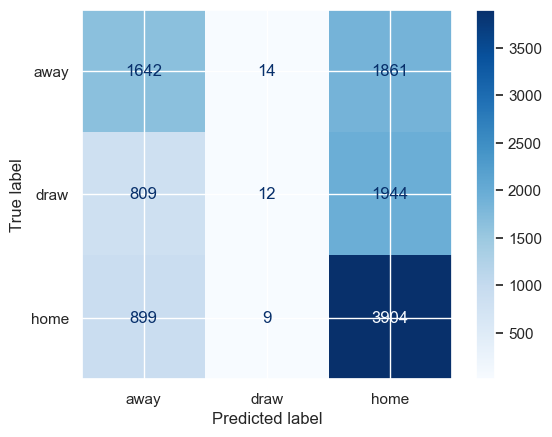

In [53]:
# Evaluate loss
val_preds = best_model.predict(X_val)
logloss = log_loss(y_val, val_preds)
print(f"Validation Log Loss: {logloss:.4f}")

# Classification report
val_classes = np.argmax(val_preds, axis=1)
print("Classification Report (LSTM):\n")
print(classification_report(y_val, val_classes, target_names=label_encoder.classes_))

# Display confusion matrix
cm = confusion_matrix(y_val, val_classes)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')

In [55]:
# Generate Submission
test_df = clean_match_data(test_df) 
X_array_test = test_df[sequence_features].values
X_test = X_array_test.reshape((len(test_df), timesteps, len(history_features) * 2))
test_preds = best_model.predict(X_test)

submission_df = pd.DataFrame(test_preds, columns=label_encoder.classes_)
submission_df = submission_df[['home', 'draw', 'away']]
submission_df.insert(0, 'id', test_df['id'])
submission_df.to_csv('submission.csv', index=False)

2273/2273 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


## Comparison Model: Logistic Regression

LSTM model will be compared it against a simpler baseline model — **Logistic Regression** to determine if LSTM is actually an optimal solution for this problem

/Users/olaniyinafiu/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Log Loss (Logistic Regression): 1.0106
Classification Report:
               precision    recall  f1-score   support

        away       0.48      0.45      0.47      3517
        draw       0.37      0.01      0.02      2765
        home       0.50      0.81      0.62      4812

    accuracy                           0.50     11094
   macro avg       0.45      0.42      0.37     11094
weighted avg       0.46      0.50      0.42     11094



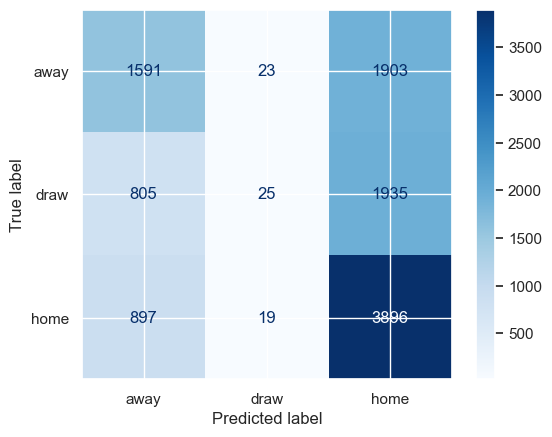

In [56]:
# Flatten sequence features for logistic regression
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
lr.fit(X_train_flat, y_train)
lr_preds = lr.predict_proba(X_val_flat)

# Evaluate loss
lr_logloss = log_loss(y_val, lr_preds)
print(f"Log Loss (Logistic Regression): {lr_logloss:.4f}")

# Classification report
lr_classes = lr.predict(X_val_flat)
print("Classification Report:\n", classification_report(y_val, lr_classes, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_val, lr_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')

## Model Comparison: LSTM vs Logistic Regression

| Metric                | LSTM              | Logistic Regression       |
|------------------------|-------------------|----------------------------|
| Validation Accuracy    | 50.1%             | 50.0%                      |
| Validation Log Loss    | 1.0116            | 1.0106                     |
| Kaggle Log Loss        | 1.00708           | —                          |
| Public LB Score        | 1.01550           | —                          |

---

### Per-Class Breakdown

| Label  | Precision (LSTM) | Recall (LSTM) | Precision (LR) | Recall (LR) |
|--------|------------------|---------------|----------------|-------------|
| Away   | 0.49             | 0.47          | 0.48           | 0.45        |
| Draw   | 0.34             | 0.00          | 0.37           | 0.01        |
| Home   | 0.51             | 0.81          | 0.50           | 0.81        |

---

## Confusion Matrix Insight

- Home wins have the highest prediction accuracy.
- Draws are heavily under-predicted.
- LSTM performs slightly better for away outcomes compared to logistic regression.

---

## Conclusion

This project explored deep learning for football match outcome prediction using historical sequence data.

### Key Insights:
- The LSTM model outperformed the logistic regression baseline in terms of log loss, the official competition metric.
- Accuracy across both models was similar, but the LSTM is better equipped to model temporal patterns.
- The hardest class to predict is draw, indicating future work should:
  - Apply class balancing techniques.
  - Explore more advanced architectures such as Transformers or attention mechanisms.

---

## Final Submission Summary

- Kaggle Log Loss: `1.00708`  
- Public Leaderboard Score: `1.01550`  
- The LSTM model shows a promising direction for sports sequence modeling with room for further optimization.
